<a href="https://colab.research.google.com/github/TylerWichman/Tyler_Wichman_Portfolio/blob/main/Sales_Performance_Classification/Sales_Performance_Classification_Workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting High-Performing Sales Representatives  
###A Logistic Regression Classification Project

## Project Overview
Sales organizations often want to identify which representatives are likely to become high performers in order to target coaching, hiring, and incentive strategies.  

In this project, I build a logistic classification model to predict whether a sales representative is a high performer based on historical performance and behavioral data.

## Why This Matters
Accurately identifying high-performing sales reps can help organizations:
- Allocate coaching and resources more effectively
- Improve hiring decisions
- Design better compensation and incentive structures

## Approach
- Define a binary outcome variable (`High_Performer`)
- Train a logistic regression model for interpretability
- Evaluate performance using classification metrics

> Note: All data used in this analysis has been anonymized.

##Summary
This project develops an interpretable classification model to identify high-performing sales representatives using demographic, experience, compensation, and business-unit features. Defining high performers as the top 20% based on NPS and customer feedback. The model shows that threshold-tuned probability scores can meaningfully increase high-performer identification relative to the baseline, enabling coaching and incentive decisions aligned with business priorities.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
accuracy_score,
precision_score,
recall_score,
f1_score,
classification_report,
confusion_matrix,
ConfusionMatrixDisplay
)

np.random.seed(13)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel("/content/drive/MyDrive/TechSales.xlsx")

## Data Overview

Before building any model, it is important to understand the structure and contents of the dataset.

In this section, we:
- Examine the shape of the dataset
- Preview a few rows
- Check for missing values

This helps ensure that preprocessing and modeling decisions are grounded in the data itself.

In [ ]:
print(df.shape)
df.head()

(21990, 11)


,Sales_Rep,Business,Age,Female,Years,College,Personality,Certficates,Feedback,Salary,NPS
0,1,Hardware,59,1,2,Yes,Diplomat,1,2.01,70200,5
1,2,Hardware,52,0,10,Yes,Diplomat,4,3.64,133000,10
2,3,Software,47,1,1,Yes,Explorer,1,3.88,52600,8
3,4,Hardware,61,0,2,Yes,Diplomat,3,2.70,96000,6
4,5,Software,39,0,1,No,Diplomat,5,3.44,122000,7


In [ ]:
missing = (df.isna().sum().sort_values(ascending=False))

missing_pct = (missing / len(df) * 100).round(2)

missing_summary = pd.DataFrame({
    "missing_count": missing,
    "missing_pct": missing_pct
}).query("missing_count > 0")

missing_summary

,missing_count,missing_pct


No missing values

## Target Definition: `High_Performer`

To model high performance as a binary classification task, we define `High_Performer` using an objective threshold.

Definition used in this notebook:
- `High_Performer = 1` if a representative is in the **top 20%** of both NPS (Net Performance Score) and Customer Feedback
- `High_Performer = 0` otherwise


>This definition ensures that
high performers excel across multiple performance dimensions rather than one metric.

In [ ]:
nps_cutoff = df["NPS"].quantile(0.80)
feedback_cutoff = df["Feedback"].quantile(0.80)

# Assign High_Performer
df["High_Performer"] = (
    (df["NPS"] >= nps_cutoff) &
    (df["Feedback"] >= feedback_cutoff)
).astype(int)

# Inspect class balance
df["High_Performer"].value_counts()

,count
High_Performer,
0,20388
1,1602


Because `High_Performer` is defined using NPS and Feedback, those columns can't be used as model inputs.
Including them would leak the answer into the features and inflate performance.

In [ ]:
y = df["High_Performer"]

leakage_cols = ["NPS", "Feedback", "High_Performer"]
id_cols = ["Sales_Rep", "EmployeeID", "ID", "Name"]

drop_cols = []

for col in leakage_cols:
  if col in df.columns:
    drop_cols.append(col)

for col in id_cols:
  if col in df.columns:
    drop_cols.append(col)

X = df.drop(columns=drop_cols)

X = pd.get_dummies(X, drop_first=True)

## Model: Logistic Regression

Because the positive class (high performers) is proportionally smaller, we use `class_weight="balanced"` to reduce bias toward the majority class.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.25, random_state=13, stratify=y)


model = LogisticRegression(class_weight="balanced", max_iter=1000)
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred = model.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall:", round(recall_score(y_test, y_pred), 3))
print("F1:", round(f1_score(y_test, y_pred), 3))


print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=3))

Accuracy: 0.758
Precision: 0.192
Recall: 0.723
F1: 0.303

Classification Report:

              precision    recall  f1-score   support

           0      0.972     0.760     0.853      5097
           1      0.192     0.723     0.303       401

    accuracy                          0.758      5498
   macro avg      0.582     0.742     0.578      5498
weighted avg      0.915     0.758     0.813      5498



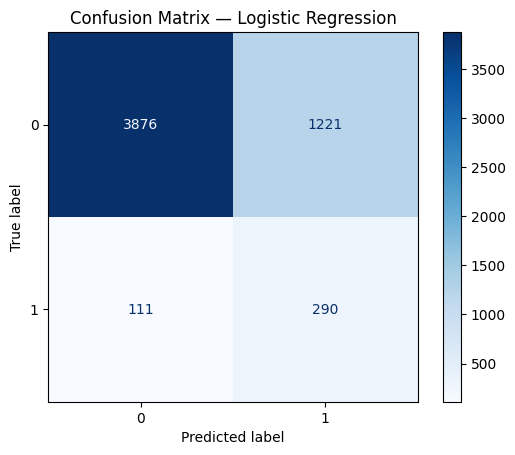

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)


disp.plot(cmap="Blues",values_format="d")
plt.title("Confusion Matrix — Logistic Regression")
plt.show()

In [ ]:
y_proba = model.predict_proba(X_test)[:, 1]


thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
rows = []


for t in thresholds:
  preds = (y_proba >= t).astype(int)
  rows.append({
  "threshold": t,
  "precision": precision_score(y_test, preds),
  "recall": recall_score(y_test, preds),
  "f1": f1_score(y_test, preds)
  })


pd.DataFrame(rows)

,threshold,precision,recall,f1
0,0.3,0.132526,0.900249,0.231040
1,0.4,0.159322,0.820449,0.266829
2,0.5,0.191926,0.723192,0.303347
3,0.6,0.224932,0.620948,0.330239
4,0.7,0.250678,0.461347,0.324846


## Final Analysis

### Baseline Model Performance (Default Threshold = 0.5)

Using the standard probability threshold of 0.5, the logistic regression model achieves:
- **Accuracy:** 75.8%
- **Recall (High Performers):** 72.3%
- **Precision (High Performers):** 19.2%

This indicates that the model is effective at identifying most true high performers, but it does so at the cost of a high false-positive rate. Many individuals flagged as high performers are not actually in the top performance group.

This tradeoff makes the default model well-suited for an early-stage screening or exploratory talent analysis, where the cost of missing a strong performer is higher than the cost of reviewing additional candidates. The model is not appropriate for decisions such as promotions or compensation without further refinement.

### Threshold Adjustment & Business Tradeoffs

Because logistic regression outputs probabilities rather than fixed decisions, the classification threshold can be adjusted to better align with business objectives.

As the threshold increases:
- Precision improves (fewer false positives)
- Recall decreases (more true high performers are missed)

Evaluating multiple thresholds shows that a threshold between 0.6 and 0.7 provides the most balanced tradeoff:

Threshold selection should be driven by the situation:
- Lower thresholds (0.5): Broad screening, coaching, development pipelines
- Higher thresholds (0.7): Targeted interventions, leadership development, succession planning


### Key Takeaways

This analysis demonstrates that model performance cannot be evaluated using a single metric or threshold in isolation. By adjusting the probability threshold, the same model can support multiple business objectives, reinforcing the importance of aligning analytical decisions with real-world costs and priorities.

Future improvements could include non-linear models, additional behavioral features, and validation on future performance periods to further refine decision-making accuracy.